### Modeling - Loan Offer Predictive Model
This notebook builds upon the work done in pre-processing and models our data in three different ways: <br>
1) K-Nearest Neighbors <br>
2) Logistic Regression <br>
3) Gradient Boosting

In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
with sqlite3.connect('bank.sqlite') as conn:
    df = pd.read_sql_query('SELECT * FROM clean_table', conn)

df.head()

,age,experience,income,zip,family,cc_avg,education,mortgage,personal_loan,securiities_account,cd_account,online,credit_card
0,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [3]:
# Saw in EDA that ZIP Code didn't have a huge impact on loan offers being accepted. Removing that.
df = df.drop('zip', axis=1)

In [4]:
# Heavily imbalanced dataset in terms of what we're classifying
df.personal_loan.value_counts()

0    4468
1     480
Name: personal_loan, dtype: int64

In [5]:
# Split data into X and y
X = df.drop('personal_loan', axis =1 )
y = df.personal_loan

In [6]:
# Scale X
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [7]:
# Split X and y
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = .25, random_state = 5)

In [8]:
# Use SMOTE to address imalanced data
oversample = SMOTE(random_state = 5)
X_train_res, y_train_res = oversample.fit_sample(X_train, y_train)

In [9]:
# We see before SMOTE that rejected offers represented roughly 9x as many observations in training as accepted offers
print('Accepted loan offers in training before SMOTE: {}'.format(sum(y_train == 1)))
print('Rejected loan offers in training before SMOTE: {}'.format(sum(y_train == 0)))

Accepted loan offers in training before SMOTE: 373
Rejected loan offers in training before SMOTE: 3338


In [10]:
# With SMOTE, we synthetically oversample to get accepted offers to be the same as rejected offers
print('Accepted loan offers in training after SMOTE: {}'.format(sum(y_train_res == 1)))
print('Rejected loan offers in training after SMOTE: {}'.format(sum(y_train_res == 0)))

Accepted loan offers in training after SMOTE: 3338
Rejected loan offers in training after SMOTE: 3338


In [11]:
# We see a corresponding increase in rows for X_train_res now that we've used SMOTE
print(X_train.shape)
print(X_train_res.shape)

(3711, 11)
(6676, 11)


### K-Nearest Neighbors (KNN)

In [12]:
# Computing train and test scores for KNN between 1 and 10
test_scores = []
train_scores = []

for i in range(1,10):
    knn = KNeighborsClassifier(i)
    knn.fit(X_train_res, y_train_res)
    train_scores.append(knn.score(X_train_res, y_train_res))
    test_scores.append(knn.score(X_test, y_test))

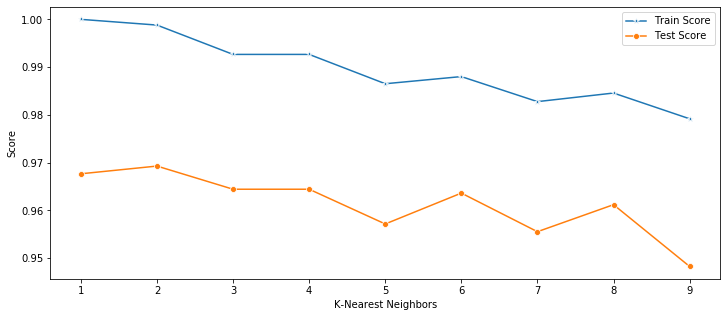

In [13]:
plt.figure(figsize=(12,5))
plt.xlabel('K-Nearest Neighbors')
plt.ylabel('Score')
_ = sns.lineplot(range(1,10), train_scores, marker = '*', label = 'Train Score')
_ = sns.lineplot(range(1,10), test_scores, marker='o', label = 'Test Score')

In [14]:
# Index 0 in test_scores is KNN = 1, so optimal KNN is index value + 1 of max element in test_scores
test_scores.index(max(test_scores))+1

2

In [15]:
knn = KNeighborsClassifier(2)
knn.fit(X_train_res, y_train_res)
knn.score(X_test, y_test)

0.9692805173807599

In [16]:
from sklearn.metrics import confusion_matrix as cm
y_pred = knn.predict(X_test)
cm(y_pred, y_test)

array([[1118,   26],
       [  12,   81]], dtype=int64)

The rows are predicted, the columns are actual. Here, our algorithm interprets not accepting the loan offer as a positive, and accepting the loan offer as negative.<br>
True Positives = 1,118 <br>
False Positives = 26 <br>
True Negatives = 81 <br>
False Negatives = 12

In [17]:
from sklearn.metrics import classification_report as cr
print(cr(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1144
           1       0.76      0.87      0.81        93

    accuracy                           0.97      1237
   macro avg       0.87      0.92      0.90      1237
weighted avg       0.97      0.97      0.97      1237



Accuracy = (True Positives + True Negatives) / (Total # of Predictions) <br>
Precision (Positive Predictive Value) = True Positives / (True Positives + False Positives) <br>
Recall (Sensitivity) = True Positives / (True Positives + False Negatives) <br>
Specificity (True Negative Rate) = True Negatives / (True Negatives + False Positives)


The optimal KNN value we have computed was only over a list of up to 10 values. To perform a more comprehensive optimization, we'll use Grid Search over a larger range of values.

In [18]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, cv = 5)
knn_cv.fit(X_train_res,y_train_res)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [19]:
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.9895152391845523
Best Parameters: {'n_neighbors': 2}
